In [1]:
import os 
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.MSI.run_meta.organized.tsv', sep='\t')
dict_HRRid_to_metadata = { tup.Accession : [tup.SampleID, tup.PatientID, tup.TreatmentStage, tup.BiopsySite, tup.TMB, tup.Response ] for tup in df_metadata.itertuples() }

## Prepare analysis

### Check processed/unprocessed samples

In [38]:
df_metadata_PR = df_metadata[   (df_metadata['Response']=='PR') & 
                                (df_metadata['BiopsySite'].isin(['Adjacent normal tissue', 'Tumor'])) & 
                                (df_metadata['LibraryType']=='scRNA-seq')
                            ].copy()

DIR_cellranger_tumor_out    = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Tumor'
DIR_cellranger_normal_out   = '/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/Adjacent_normal_tissue'

processed_samples_summary = list()

for tup in df_metadata_PR.itertuples():
    HRRid = tup.Accession
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out
    elif tup.BiopsySite == 'Adjacent normal tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    else:
        raise ValueError
    
    temp_entry = [HRRid]
    if os.path.exists( f'{DIR_cellranger_out_t}/{HRRid}/outs' ) == True:
        bool_cellranger_processed = True
        # Check scrublet
        if os.path.exists(f'{DIR_cellranger_out_t}/{HRRid}/outs/filtered_feature_bc_matrix.scrublet.h5') == True:
            bool_scrublet_processed = True 
        else:
            bool_scrublet_processed = False
        # Check NanoMnT
        if os.path.exists( f'{DIR_cellranger_out_t}/{HRRid}/outs/possorted_genome_bam.STR_allele_table.tsv' ) == True:
            bool_NanoMnT_processed = True
        else: 
            bool_NanoMnT_processed = False 
    else:
        bool_cellranger_processed = False
        bool_scrublet_processed = False
        bool_NanoMnT_processed = False
    
    for md in  dict_HRRid_to_metadata[HRRid]:
        temp_entry.append(md)
        
    temp_entry.append( bool_cellranger_processed )
    temp_entry.append( bool_scrublet_processed )
    temp_entry.append( bool_NanoMnT_processed )
    
    processed_samples_summary.append( temp_entry )

processed_samples_summary = pd.DataFrame(processed_samples_summary)
processed_samples_summary.columns = ['HRRid', 'SampleID', 'PatientID', 'TreatmentStage', 'BiopsySite', 'TMB', 'Response', 'cellranger', 'scrublet', 'nanomnt']

### Selectively run scrublet for un-processed samples

In [ ]:
for tup in processed_samples_summary[(processed_samples_summary['cellranger']==True) & (processed_samples_summary['scrublet']==False)]:
    
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out
    elif tup.BiopsySite == 'Adjacent normal tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    else:
        raise ValueError
    
    adata_t = sc.read_10x_h5( f'{DIR_cellranger_out_t}/outs/filtered_feature_bc_matrix.h5' )    # Scrublet has yet to be done

    adata_t.obs['HRR_id']    = tup.HRRid
    adata_t.obs['SampleID']  = tup.SampleID
    adata_t.obs['PatientID'] = tup.PatientID
    adata_t.obs['TreatmentStage']  = tup.TreatmentStage
    adata_t.obs['BiopsySite']  = tup.BiopsySite
    adata_t.obs['TMB']  = tup.TMB
    adata_t.obs['Response']  = tup.Response
    
    adata_t.obs_names_make_unique()
    adata_t.var_names_make_unique()
    sc.pp.scrublet(adata_t)
    adata_t.write(f'{DIR_cellranger_out_t}/outs/filtered_feature_bc_matrix.scrublet.h5')
    
#! You might want to update processed_samples_summary after running this

## Start analysis (temp; processed files only)

In [288]:
processed_samples_summary[(processed_samples_summary['nanomnt']==True)]

,HRRid,SampleID,PatientID,TreatmentStage,BiopsySite,TMB,Response,cellranger,scrublet,nanomnt
9,HRR1373479,P15-T-I,P15,Pre,Tumor,Not avaliable,PR,True,True,True
14,HRR1373858,P15-T-II,P15,Post,Tumor,Not avaliable,PR,True,True,True
15,HRR1373857,P15-T-II,P15,Post,Tumor,Not avaliable,PR,True,True,True
26,HRR1373526,P17-T-I,P17,Pre,Tumor,67.7,PR,True,True,True
29,HRR1373551,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True
30,HRR1373550,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True
31,HRR1373549,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True
44,HRR1373604,P19-T-I,P19,Pre,Tumor,54.54,PR,True,True,True
45,HRR1373603,P19-T-I,P19,Pre,Tumor,54.54,PR,True,True,True
46,HRR1373602,P19-T-I,P19,Pre,Tumor,54.54,PR,True,True,True


In [289]:
processed_samples_summary_oi = processed_samples_summary[(processed_samples_summary['nanomnt']==True) & (processed_samples_summary['PatientID']=='P19')].copy()
processed_samples_summary_oi 

,HRRid,SampleID,PatientID,TreatmentStage,BiopsySite,TMB,Response,cellranger,scrublet,nanomnt
26,HRR1373526,P17-T-I,P17,Pre,Tumor,67.7,PR,True,True,True
29,HRR1373551,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True
30,HRR1373550,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True
31,HRR1373549,P17-T-II,P17,Post,Tumor,67.7,PR,True,True,True


In [184]:
list_adata = list()
list_alleleTable = list()

for tup in processed_samples_summary_oi.itertuples():
    if tup.BiopsySite == 'Tumor':
        DIR_cellranger_out_t = DIR_cellranger_tumor_out 
    elif tup.BiopsySite == 'Normal adjacent tissue':
        DIR_cellranger_out_t = DIR_cellranger_normal_out
    
    adata_t = sc.read_h5ad( f'{DIR_cellranger_out_t}/{tup.HRRid}/outs/filtered_feature_bc_matrix.scrublet.h5' )
    
    alleleTable = pd.read_csv( f'{DIR_cellranger_out_t}/{tup.HRRid}/outs/possorted_genome_bam.STR_allele_table.tsv', sep='\t' )
    alleleTable['HRRid'] = tup.HRRid
    alleleTable['PatientID'] = tup.PatientID
    alleleTable['TreatmentStage'] = tup.TreatmentStage
    alleleTable['BiopsySite'] = tup.BiopsySite
    alleleTable['Response'] = tup.Response

    list_adata.append( adata_t )
    list_alleleTable.append( alleleTable )

### Scanpy preprocessing

In [46]:
adata = sc.concat( list_adata  )
adata.var = list_adata[0].var
adata.obs_names_make_unique()

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [52]:
adata.write('/node200data/18parkky/datasets/data/public/BAM/Immunotherapy_CRC_Chen_et_al/MSI/merged_adata.1114.h5')

In [53]:
print(adata.shape)
adata = adata[adata.obs['doublet_score']<=0.1]
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)

adata.raw = adata
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=4000, batch_key="SampleID")
adata = adata[:, adata.var.highly_variable]

sc.tl.pca(adata, svd_solver="arpack")

sc.pp.neighbors(adata, n_pcs=20, use_rep='X_pca')
sc.tl.umap(adata)

for res in [0.02, 0.1, 0.2, 0.3, 0.5, 1.0]:
    # print(res)
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

(15615, 36601)
(14507, 36601)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


(10144, 20634)


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 12:30:04.502219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 12:30:04.528724: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 12:30:05.013673: I external/local_xla/

In [260]:
df_iCMS_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv')

iCMS2_up = list(df_iCMS_marker['iCMS2_Up'].dropna())
iCMS2_dw = list(df_iCMS_marker['iCMS2_Down'].dropna())
iCMS3_up = list(df_iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(df_iCMS_marker['iCMS3_Down'].dropna())

sc.tl.score_genes(adata, iCMS3_up, score_name='iCMS3_up')
sc.tl.score_genes(adata, iCMS3_dw, score_name='iCMS3_dw')

### Overlay NanoMnT results

In [185]:
alleleTable = pd.concat(list_alleleTable)
alleleTable.reset_index(inplace=True, drop=True)

In [186]:
# filter out low-quality NanoMnT entries
alleleTable_f = list()
for tup in alleleTable.itertuples():
    if ("*" in tup.left_flanking_seq[-3:]) or ("*" in tup.right_flanking_seq[:3]) or (tup.left_flanking_seq[-1].upper() == tup.repeat_unit) or (tup.right_flanking_seq[0].upper() == tup.repeat_unit):
        continue
    else:
        alleleTable_f.append( tup )
        
alleleTable_f = pd.DataFrame(alleleTable_f)
alleleTable_f.drop('Index', axis=1, inplace=True)
alleleTable_f.dropna(inplace=True)

In [187]:
adata.obs['CB_wHRRid'] = [ f'{tup.Index}-{tup.HRR_id}' for tup in adata.obs.itertuples() ]
alleleTable_f['CB_wHRRid'] = [ f'{tup.CB}-{tup.HRRid}' for tup in alleleTable_f.itertuples() ]
alleleTable_f['diff'] = alleleTable_f['read_STR_length'] - alleleTable_f['reference_STR_allele']

In [191]:
dict_CBwHRRid_to_STRprofile = { CBwHRRid : [np.mean(edf['diff']), len(edf)] for CBwHRRid, edf in alleleTable_f.groupby("CB_wHRRid") }

In [193]:
for CBwHRRid in adata.obs['CB_wHRRid']:
    try: dict_CBwHRRid_to_STRprofile[CBwHRRid]
    except KeyError: dict_CBwHRRid_to_STRprofile[CBwHRRid] = [ -1, -1 ]

In [194]:
adata.obs['RawAvgSTR']  = [ dict_CBwHRRid_to_STRprofile[CBwHRRid][0] for CBwHRRid in adata.obs['CB_wHRRid']]
adata.obs['RawSTRn']    = [ dict_CBwHRRid_to_STRprofile[CBwHRRid][1] for CBwHRRid in adata.obs['CB_wHRRid']]

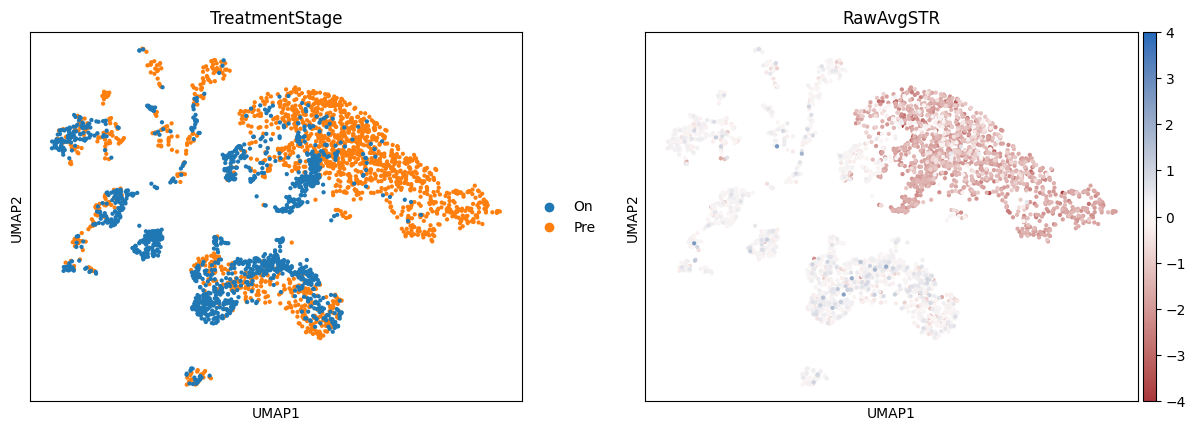

In [211]:
sc.pl.umap(adata[adata.obs['RawSTRn']>=10], color=['TreatmentStage', 'RawAvgSTR', ], cmap='vlag_r', ncols=2, vmin=-4, vmax=4)

In [261]:
tumor_cluster = [ '0', '4', '5', '8', '15', ]
adata_tumor = adata[adata.obs['leiden_res_0.30'].isin(tumor_cluster)].raw.to_adata().copy()
adata_tumor.raw = adata_tumor
adata_tumor.layers["counts"] = adata_tumor.X.copy()

sc.pp.highly_variable_genes(adata_tumor, n_top_genes=4000, batch_key="SampleID")
adata_tumor = adata_tumor[:, adata_tumor.var.highly_variable]

sc.tl.pca(adata_tumor, svd_solver="arpack")

sc.pp.neighbors(adata_tumor, n_pcs=20, use_rep='X_pca')
sc.tl.umap(adata_tumor)

for res in [0.02, 0.1, 0.2, 0.3, 0.5, 1.0]:
    sc.tl.leiden(
        adata_tumor, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


<Axes: xlabel='RawAvgSTR', ylabel='SubCellType'>

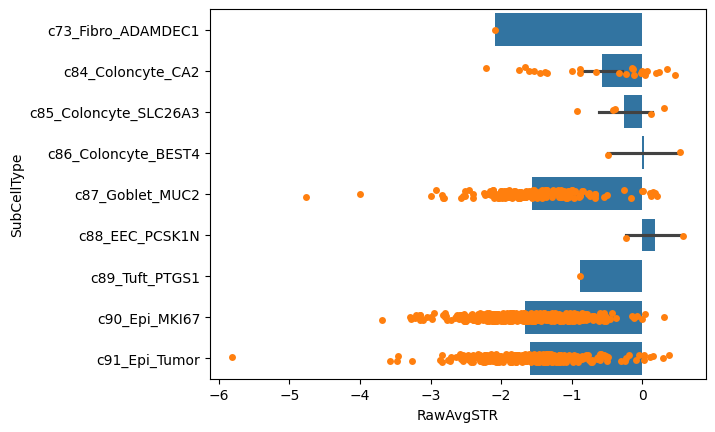

In [294]:
# sns.barplot(data=adata_tumor[adata_tumor.obs['SubCellType']=='c91_Epi_Tumor'].obs)
sns.barplot(data=adata_tumor[adata_tumor.obs['RawSTRn']>=10].obs, x='RawAvgSTR', y='SubCellType')
sns.stripplot(data=adata_tumor[adata_tumor.obs['RawSTRn']>=10].obs, x='RawAvgSTR', y='SubCellType')

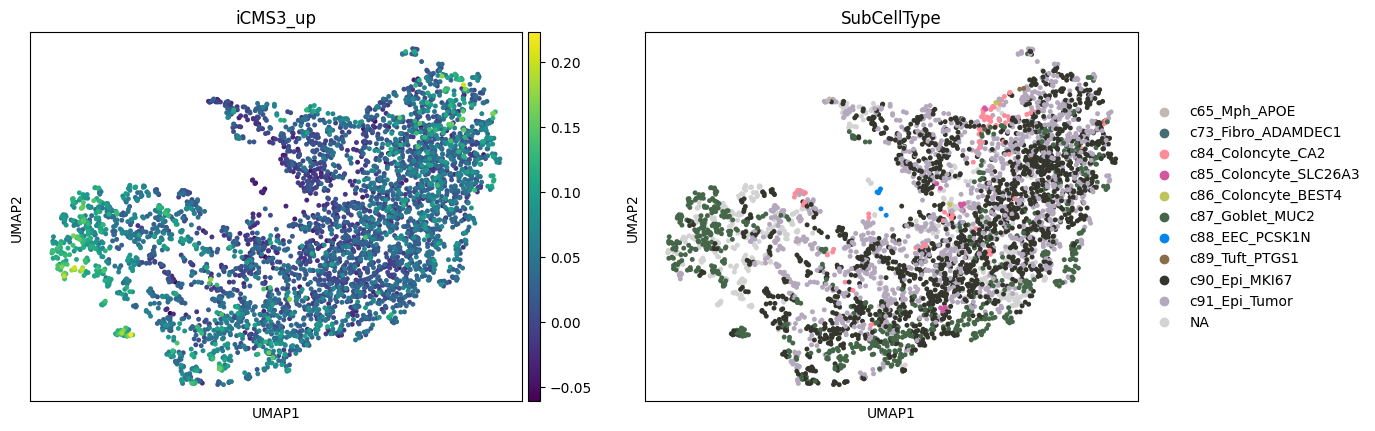

In [290]:
sc.pl.umap(adata_tumor, color=['iCMS3_up', 'SubCellType'], s=50)

<Axes: xlabel='iCMS3_up', ylabel='RawAvgSTR'>

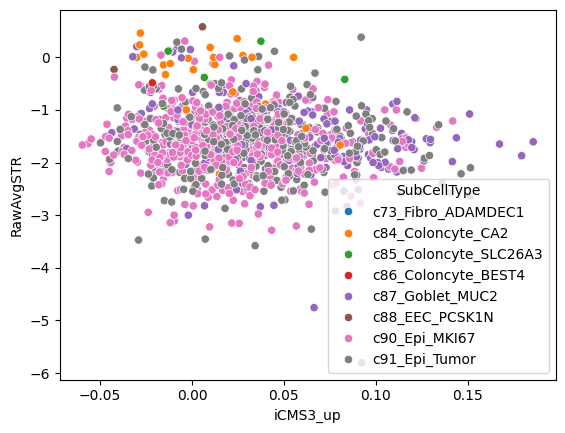

In [278]:
sns.scatterplot(data=adata_tumor[adata_tumor.obs['RawSTRn']>=20].obs, x='iCMS3_up', y='RawAvgSTR', hue='SubCellType')

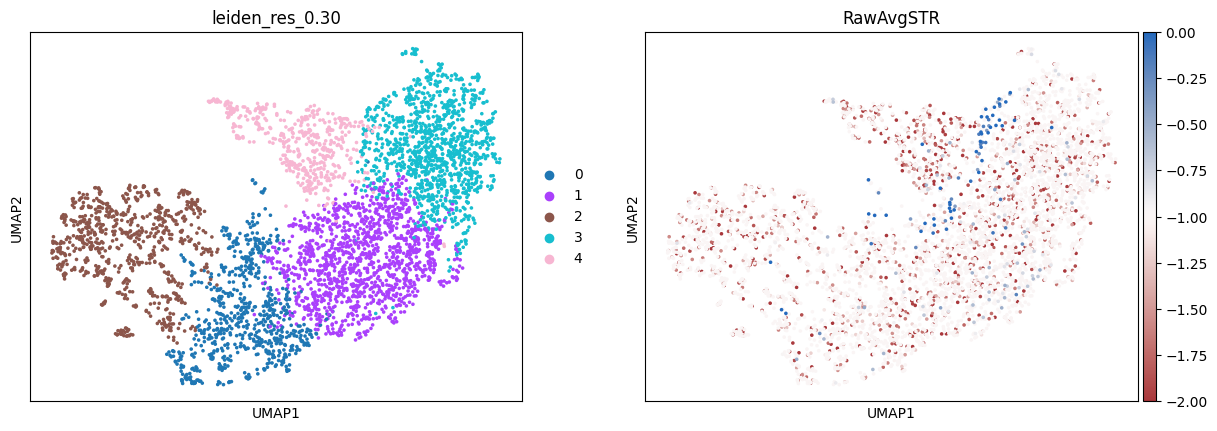

In [259]:
sc.pl.umap(adata_tumor, color=['leiden_res_0.30', 'RawAvgSTR'], cmap='vlag_r', vmin=-2, vmax=0)

<Axes: xlabel='RawAvgSTR', ylabel='Density'>

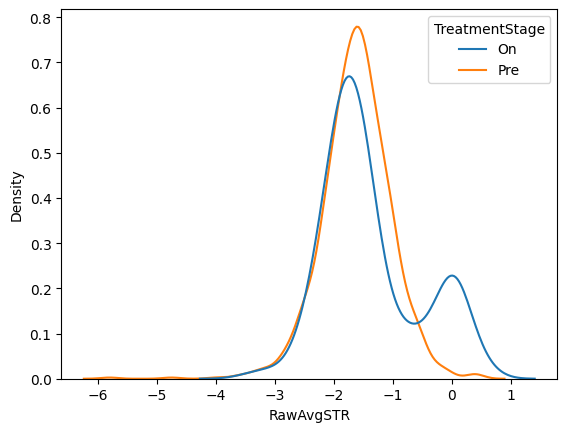

In [275]:
sns.kdeplot(data=adata_tumor[adata_tumor.obs['RawSTRn']>=10].obs, hue='TreatmentStage', x='RawAvgSTR', common_norm=False)

<Axes: xlabel='RawAvgSTR', ylabel='SubCellType'>

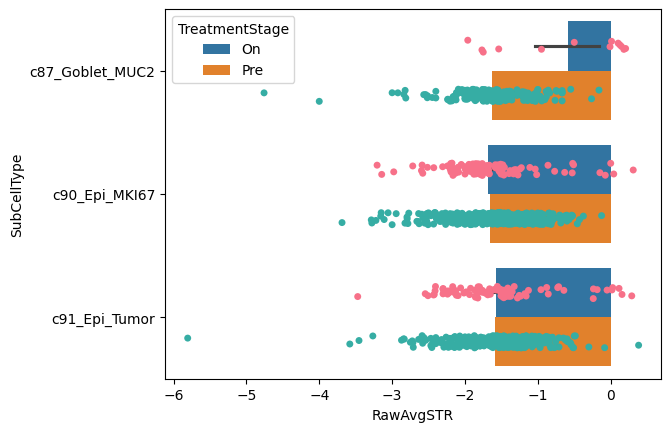

In [287]:
sns.barplot(data=adata_tumor[(adata_tumor.obs['RawSTRn']>=10) & (adata_tumor.obs['SubCellType'].isin(['c87_Goblet_MUC2', 'c90_Epi_MKI67', 'c91_Epi_Tumor']))].obs, 
            y='SubCellType', x='RawAvgSTR', hue='TreatmentStage')
sns.stripplot(data=adata_tumor[(adata_tumor.obs['RawSTRn']>=10)& (adata_tumor.obs['SubCellType'].isin(['c87_Goblet_MUC2', 'c90_Epi_MKI67', 'c91_Epi_Tumor']))].obs, 
              y='SubCellType', x='RawAvgSTR', hue='TreatmentStage', dodge=True, legend=None, palette='husl',)

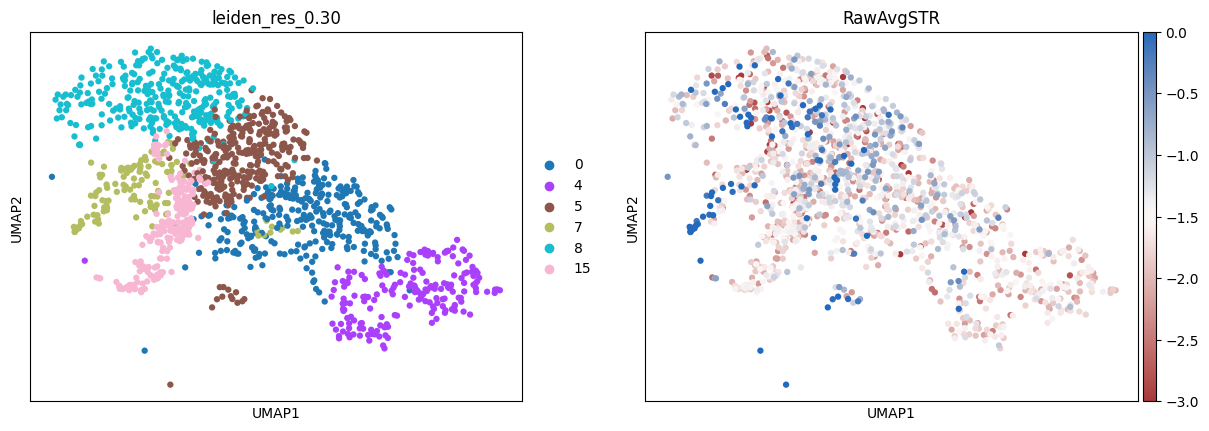

In [233]:
sc.pl.umap(adata_tumor[adata_tumor.obs['RawSTRn']>=10], color=['leiden_res_0.30', 'RawAvgSTR'], cmap='vlag_r', vmin=-3, vmax=0)

<Axes: xlabel='RawAvgSTR', ylabel='leiden_res_0.30'>

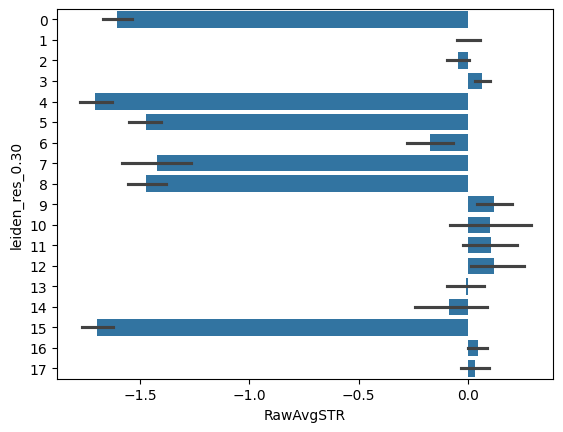

In [221]:
sns.barplot(data=adata[adata.obs['RawSTRn']>=10].obs, x='RawAvgSTR', y='leiden_res_0.30')

### Overlay Author annotaion

In [159]:
author_adata_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/AuthorProcessedData/GSE236581_CRC-ICB_metadata.txt.gz', sep=' ')
author_adata_metadata['CRC_number'] = [ Ident.split("-")[0] for Ident in author_adata_metadata['Ident'] ]
dict_patientID_to_CRCnumber = { Patient : edf.iloc[0].CRC_number for Patient, edf in author_adata_metadata.groupby("Patient") }
dict_UniqueIdentifier_to_celltype = { tup.Index : [tup.MajorCellType, tup.SubCellType] for tup in author_adata_metadata.itertuples() }

adata.obs['Cell_UniqueIdentifier'] = [ f'{dict_patientID_to_CRCnumber[tup.PatientID]}-{"-".join(tup.SampleID.split("-")[1:])}_{tup.Index.split("-")[0]}' for tup in adata.obs.itertuples() ]
for CUI in adata.obs['Cell_UniqueIdentifier']:
    try: dict_UniqueIdentifier_to_celltype[CUI]
    except KeyError: dict_UniqueIdentifier_to_celltype[CUI] = [None, None]
adata.obs['MajorCellType']  = [ dict_UniqueIdentifier_to_celltype[CUI][0] for CUI in adata.obs['Cell_UniqueIdentifier'] ]
adata.obs['SubCellType']    = [ dict_UniqueIdentifier_to_celltype[CUI][1] for CUI in adata.obs['Cell_UniqueIdentifier'] ]

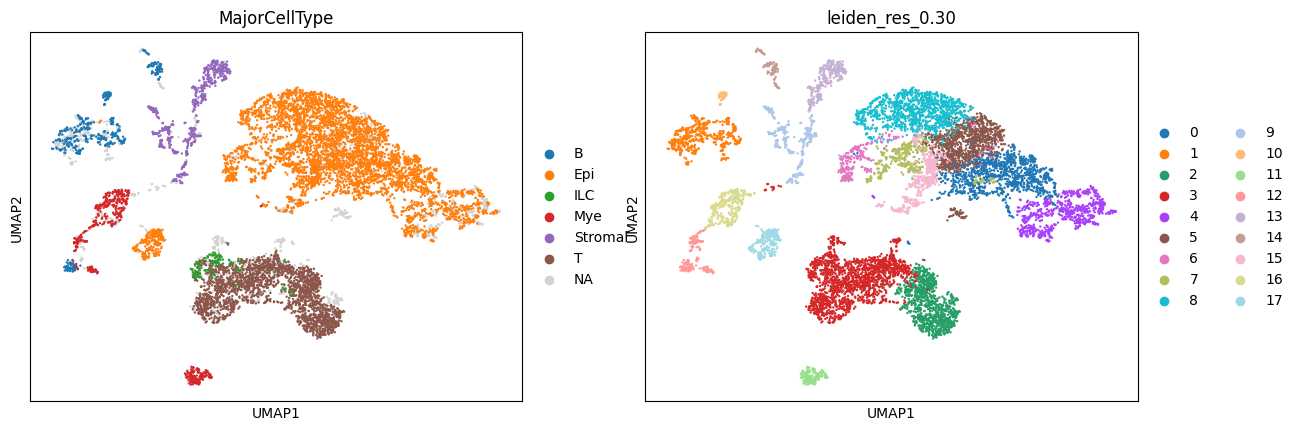

In [163]:
sc.pl.umap(adata, color=['MajorCellType', 'leiden_res_0.30',], )

### Find marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.30", method="wilcoxon")
df_ranked_gene = sc.get.rank_genes_groups_df(adata, group=None)

In [116]:
DEG_info = list()
for genename, edf in df_ranked_gene.groupby("names"):
    temp_entry = [ genename ]
    
    break


In [128]:
gene_ids = adata.raw.var.index.values
obs = adata.raw[:,gene_ids].X.toarray()
obs = pd.DataFrame(obs,columns=gene_ids,index=adata.obs['leiden_res_0.30'])

In [133]:
average_obs = obs.groupby(level=0).mean()
obs_bool = obs.astype(bool)
fraction_obs = obs_bool.groupby(level=0).sum()/obs_bool.groupby(level=0).count()


/tmp/ipykernel_231917/2494951622.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_obs = obs.groupby(level=0).mean()
/tmp/ipykernel_231917/2494951622.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraction_obs = obs_bool.groupby(level=0).sum()/obs_bool.groupby(level=0).count()


In [134]:
fraction_obs

,AL627309.1,AL627309.5,LINC01409,LINC01128,LINC00115,AL645608.6,SAMD11,NOC2L,KLHL17,PLEKHN1,...,MT-ND6,MT-CYB,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC233755.1,AC007325.2
leiden_res_0.30,,,,,,,,,,,,,,,,,,,,,
0,0.000911,0.018215,0.040073,0.038251,0.017304,0.005464,0.000911,0.228597,0.003643,0.030055,...,0.969945,1.000000,0.000000,0.019126,0.021858,0.001821,0.063752,0.012750,0.000000,0.020036
1,0.000000,0.001946,0.017510,0.052529,0.005837,0.000000,0.005837,0.147860,0.007782,0.009728,...,0.717899,0.990272,0.001946,0.040856,0.003891,0.003891,0.058366,0.005837,0.058366,0.000000
2,0.001955,0.003910,0.011730,0.020528,0.002933,0.000000,0.000000,0.105572,0.001955,0.006843,...,0.519062,0.935484,0.000000,0.017595,0.000978,0.001955,0.024438,0.000000,0.000978,0.000978
3,0.000000,0.001135,0.012486,0.037457,0.009081,0.000000,0.000000,0.082860,0.001703,0.003405,...,0.501135,0.968218,0.000000,0.026674,0.004540,0.001703,0.015323,0.000000,0.000000,0.000000
4,0.001399,0.012587,0.043357,0.090909,0.015385,0.000000,0.000000,0.432168,0.008392,0.046154,...,0.907692,0.994406,0.005594,0.078322,0.041958,0.006993,0.055944,0.022378,0.000000,0.018182
5,0.000000,0.013514,0.030888,0.023166,0.011583,0.000000,0.000000,0.124517,0.013514,0.019305,...,0.986486,1.000000,0.002896,0.011583,0.006757,0.001931,0.039575,0.012548,0.000000,0.007722
6,0.015152,0.007576,0.060606,0.113636,0.064394,0.007576,0.000000,0.102273,0.018939,0.011364,...,0.912879,0.996212,0.000000,0.071970,0.034091,0.011364,0.045455,0.060606,0.000000,0.007576
7,0.004773,0.031026,0.016706,0.040573,0.019093,0.004773,0.000000,0.178998,0.007160,0.014320,...,0.852029,0.978520,0.000000,0.019093,0.019093,0.021480,0.073986,0.004773,0.000000,0.009547
8,0.001742,0.008711,0.038328,0.033972,0.015679,0.001742,0.000000,0.073171,0.014808,0.022648,...,0.819686,0.964286,0.000871,0.008711,0.006098,0.006098,0.015679,0.003484,0.000000,0.006098


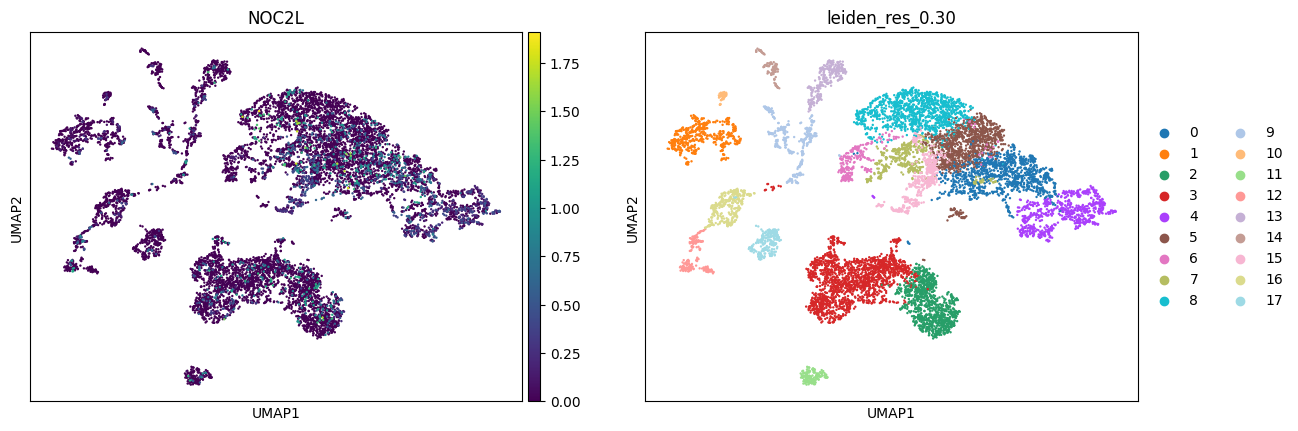

In [135]:
sc.pl.umap(adata, color=['NOC2L', 'leiden_res_0.30'])

In [118]:
edf.sort_values("logfoldchanges")

,group,names,scores,logfoldchanges,pvals,pvals_adj
121166,5,A1BG,-3.601593,-25.033978,3.162739e-04,2.272283e-03
163202,7,A1BG,-2.216605,-24.937860,2.665006e-02,1.414105e-01
143735,6,A1BG,-1.641976,-5.699785,1.005951e-01,5.042950e-01
19599,0,A1BG,-3.662752,-5.463423,2.495198e-04,2.575583e-03
329548,15,A1BG,-1.951145,-5.182065,5.103977e-02,1.639151e-01
102891,4,A1BG,-2.805246,-4.135010,5.027826e-03,1.370646e-02
182745,8,A1BG,-3.642641,-3.504090,2.698550e-04,1.587736e-03
368708,17,A1BG,-1.381433,-2.620400,1.671458e-01,7.039603e-01
286597,13,A1BG,-1.530254,-2.295004,1.259538e-01,6.778641e-01
291044,14,A1BG,0.071118,-0.411638,9.433039e-01,9.931208e-01


In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden_res_0.30", n_genes=10, swap_axes=True)

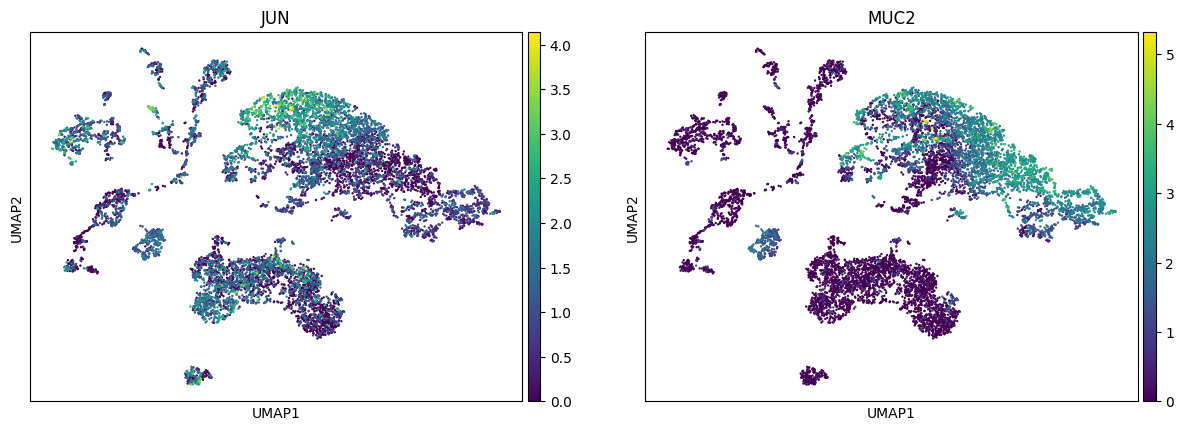

In [151]:
sc.pl.umap(adata, color=['JUN', 'MUC2'])

In [98]:
dict_leidenRes30_to_celltype_lvl0 = {
    '2' : '',
    
    '8' : 'Epithelial',
    '9' : 'Stromal',
    '10' : 'Immune',
    '11' : 'Immune',
    '12' : 'Immune',
    '13' : 'Stromal',
    '15' : 'Immune',
    '16' : 'Immune',

}

dict_leidenRes30_to_celltype_lvl1 = {
    '2' : '',
    
    '8' : 'Epithelial',
    '9' : 'Fibroblast',
    '10' : 'B/Plasma',
    '11' : 'Basophil/Progenitor immune cell',
    '12' : 'HLA-II APC',
    '13' : 'Fibroblast/Endothelial cell',
    '15' : 'B/Plasma',
    '16' : 'Neutrophil',    
}

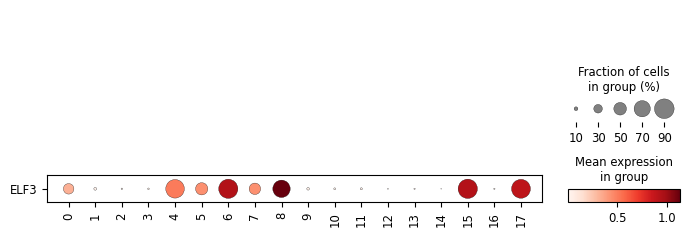

In [158]:
sc.pl.dotplot(adata, var_names=['ELF3'], groupby='leiden_res_0.30', swap_axes=True)

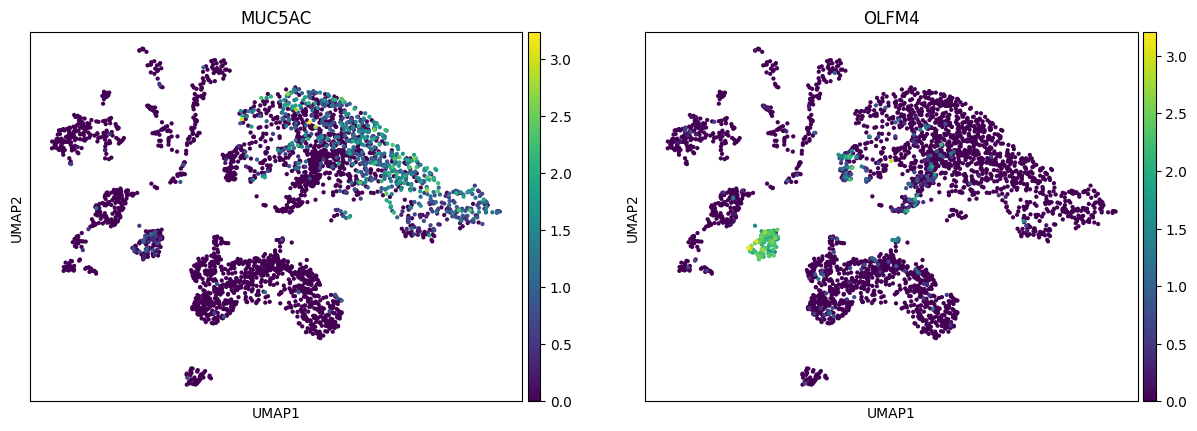

In [219]:
sc.pl.umap(adata[adata.obs['RawSTRn']>=10], color=['MUC5AC', 'OLFM4',], ncols=2, )